In [1]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
def load_image(source_path):
    filename = source_path.split('/')[-1]
    center_path = '../data/IMG/' + filename
    image = cv2.imread(center_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    return np.expand_dims(image, axis=2)

def to_normalized_gray(images):
    for i in range(len(images)):
        img = images[i]
        cv2.normalize(img, img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images[i] = img
        
    return images

def normalize_mean(x):
    r = x[:,:,:,0]   
    r_norm = (r - r.mean()) / r.std()
    
    return np.expand_dims(r_norm, axis=3)

def build_generator(csv_lines, batch_size):
    sample_shape = load_image(csv_lines[0][0]).shape
    
    while True:
        batch_features = np.zeros((0, sample_shape[0], sample_shape[1], sample_shape[2]), dtype=np.float32)
        batch_labels = np.zeros((0, 1), dtype=np.float16)
        lines_num = len(csv_lines)

        for i in range(batch_size):
            idx = np.random.choice(lines_num, 1)[0]
            line = csv_lines[idx]

            image_center = load_image(line[0])
            batch_features = np.append(batch_features, image_center[None,:], axis=0)
            batch_labels = np.append(batch_labels, float(line[3]))
            
            image_left = load_image(line[1])
            batch_features = np.append(batch_features, image_left[None,:], axis=0)
            batch_labels = np.append(batch_labels, float(line[3]) + 0.1)
            
            image_right = load_image(line[2])
            batch_features = np.append(batch_features, image_right[None,:], axis=0)
            batch_labels = np.append(batch_labels, float(line[3]) - 0.1)

        augmented_features = np.zeros((0, sample_shape[0], sample_shape[1], sample_shape[2]), dtype=np.float32)
        augmented_labels = np.zeros((0, 1), dtype=np.float16)
        for feature, label in zip(batch_features, batch_labels):
            augmented_features = np.append(augmented_features, feature[None,:], axis=0)
            augmented_labels = np.append(augmented_labels, label)

            flipped_feature = cv2.flip(feature, 1)
            flipped_label = -1.0 * label
            augmented_features = np.append(augmented_features, image_center[None,:], axis=0)
            augmented_labels = np.append(augmented_labels, float(line[3]))

        augmented_features = normalize_mean(to_normalized_gray(augmented_features))
        
        yield shuffle(augmented_features, augmented_labels)

def model(train, valid, batch_size, epochs=5):
    train_csv_lines, train_batches = train
    valid_csv_lines, valid_batches = valid

    train_samples_num = len(train_csv_lines)
    train_generator = build_generator(train_csv_lines, batch_size)
    valid_samples_num = len(valid_csv_lines)
    valid_generator = build_generator(valid_csv_lines, batch_size)

    model = Sequential()
    model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 1)))
    model.add(Conv2D(24, 5, 5, subsample=(2, 2), activation="tanh"))
#     model.add(MaxPooling2D())
    model.add(Conv2D(36, 5, 5, subsample=(2, 2), activation="tanh"))
#     model.add(MaxPooling2D())
    model.add(Conv2D(48, 5, 5, subsample=(2, 2), activation="tanh"))
    model.add(Conv2D(64, 5, 5, activation="tanh"))
#     model.add(Conv2D(64, 5, 5, activation="relu"))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit_generator(train_generator, samples_per_epoch= 3 * 2 * train_samples_num, validation_data=valid_generator, nb_val_samples=3 * 2 * valid_samples_num, nb_epoch=epochs, verbose=1)

    model.summary()
    model.save('p3_model.h5')
    
    print(history_object.history.keys())
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

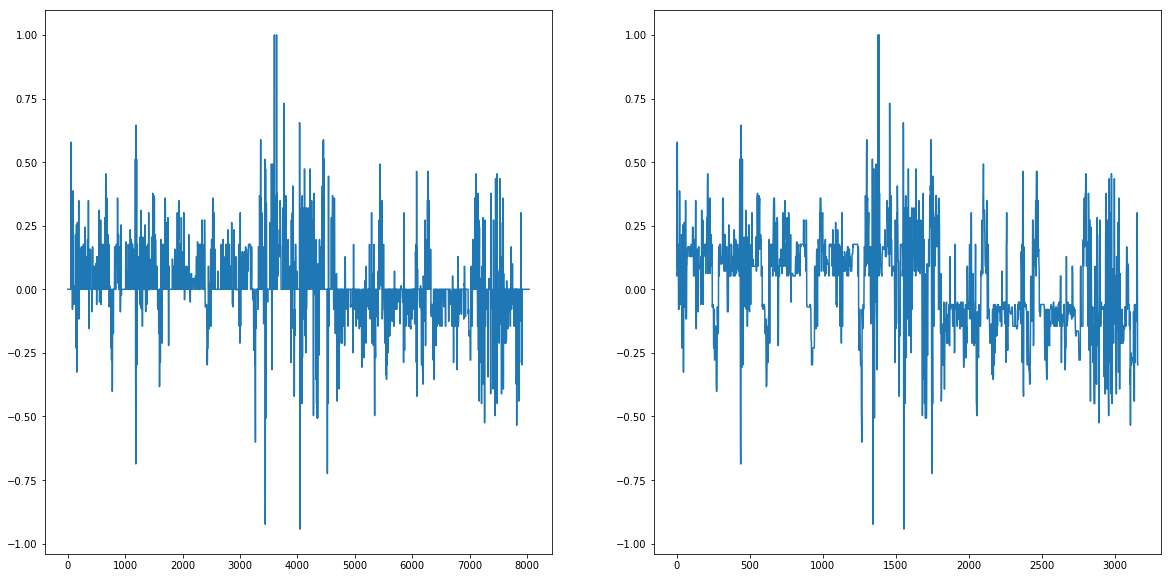

In [3]:
def read_csv():
    with open('../data/driving_log.csv', 'r') as csvfile:
        steerings = []
        filtered_steerings = []
        filtered_lines = []
        reader = csv.reader(csvfile)
        steering_limit = 0.05
        
        for i, line in enumerate(reader):
            if i != 0:
                steering = float(line[3])
                steerings.append(steering)
                
                if steering < -steering_limit or steering > steering_limit:
                    filtered_lines.append(line)
                    filtered_steerings.append(steering)
    
        return filtered_lines, steerings, filtered_steerings
    
csv_lines, steerings, filtered_steerings = read_csv()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(steerings)
ax2.plot(filtered_steerings)
plt.show()

Epoch 1/5
14976/14976 [==============================] - 1205s - loss: 4.0425 - val_loss: 0.2300
Epoch 2/5
14976/14976 [==============================] - 1005s - loss: 0.1726 - val_loss: 0.1488
Epoch 3/5
14976/14976 [==============================] - 1095s - loss: 0.1085 - val_loss: 0.0652
Epoch 4/5
14976/14976 [==============================] - 1076s - loss: 0.0636 - val_loss: 0.0519
Epoch 5/5
14976/14976 [==============================] - 1134s - loss: 0.0562 - val_loss: 0.0414
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 1)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   624         cropping2d_1[0][0]               
__________

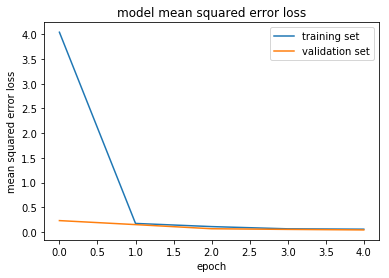

In [4]:
train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    
batch_size = 64

train_lines_num = len(train_samples)
train_batches = train_lines_num // batch_size
train_samples_num = batch_size * train_batches
train_csv_lines = train_samples[:train_samples_num]
train = train_csv_lines, train_batches

valid_lines_num = len(valid_samples)
valid_batches = valid_lines_num // batch_size
valid_samples_num = batch_size * valid_batches
valid_csv_lines = valid_samples[:valid_samples_num]
valid = valid_csv_lines, valid_batches

model(train, valid, batch_size, epochs=5)